In [1]:
# 셀 1: 기본 세팅

from pathlib import Path
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
import csv

# 노트북을 Code 폴더에서 연다고 가정
CODE_DIR = Path.cwd()
PROJECT_DIR = CODE_DIR.parent              # .../원대한_...
DIP_ROOT = PROJECT_DIR.parent              # .../DIP
DATASET_ROOT = DIP_ROOT / "dataset"        # DIP/dataset
RESULTS_VR_DIR = CODE_DIR / "results_vr"   # Code/results_vr

print("CODE_DIR      :", CODE_DIR)
print("PROJECT_DIR   :", PROJECT_DIR)
print("DIP_ROOT      :", DIP_ROOT)
print("DATASET_ROOT  :", DATASET_ROOT)
print("RESULTS_VR_DIR:", RESULTS_VR_DIR)


CODE_DIR      : c:\Users\CONSOMMES\Downloads\DIP\202311322_EIS\Code
PROJECT_DIR   : c:\Users\CONSOMMES\Downloads\DIP\202311322_EIS
DIP_ROOT      : c:\Users\CONSOMMES\Downloads\DIP
DATASET_ROOT  : c:\Users\CONSOMMES\Downloads\DIP\dataset
RESULTS_VR_DIR: c:\Users\CONSOMMES\Downloads\DIP\202311322_EIS\Code\results_vr


In [2]:
# 셀 2: 시각화 헬퍼 함수

def show_gray(img, title="", size=4):
    plt.figure(figsize=(size, size))
    plt.imshow(img, cmap="gray")
    plt.title(title)
    plt.axis("off")
    plt.show()


def show_many(images, titles=None, cols=3, size=3):
    """
    images: [img1, img2, ...]
    titles: ["t1", "t2", ...]
    """
    n = len(images)
    if titles is None:
        titles = [""] * n

    rows = (n + cols - 1) // cols
    plt.figure(figsize=(cols * size, rows * size))
    for i, (img, t) in enumerate(zip(images, titles)):
        plt.subplot(rows, cols, i + 1)
        if img.ndim == 2:
            plt.imshow(img, cmap="gray")
        else:
            plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        plt.title(t)
        plt.axis("off")
    plt.tight_layout()
    plt.show()


In [3]:
# 셀 3: blob 중에서 pupil 후보 하나 고르는 함수

def select_best_pupil_blob(
    stats: np.ndarray,
    centroids: np.ndarray,
    labels: np.ndarray,
    area_min: int = 80,
    area_max: int = 5000,
    circularity_min: float = 0.35,
    aspect_min: float = 0.5,
    aspect_max: float = 2.0,
):
    """
    connectedComponentsWithStats 결과에서 '가장 pupil 같아 보이는' blob 하나 선택.
    반환: (cx, cy, r) 또는 (None, None, None)
    """
    num_labels = stats.shape[0]
    best = None
    best_score = 0.0

    for i in range(1, num_labels):  # 0은 배경
        area = stats[i, cv2.CC_STAT_AREA]
        if area < area_min or area > area_max:
            continue

        w_box = stats[i, cv2.CC_STAT_WIDTH]
        h_box = stats[i, cv2.CC_STAT_HEIGHT]
        if h_box == 0:
            continue

        aspect = float(w_box) / float(h_box)
        if not (aspect_min < aspect < aspect_max):
            continue

        # 컨투어로 원형도 계산
        comp_mask = (labels == i).astype("uint8") * 255
        cnts, _ = cv2.findContours(comp_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        if not cnts:
            continue
        cnt = cnts[0]

        peri = cv2.arcLength(cnt, True)
        if peri == 0:
            continue

        circularity = 4.0 * np.pi * area / (peri * peri)
        if circularity < circularity_min:
            continue

        score = circularity * area
        if score > best_score:
            cx, cy = centroids[i]
            r = np.sqrt(area / np.pi)
            best = (float(cx), float(cy), float(r))
            best_score = score

    if best is None:
        return None, None, None
    return best


In [4]:
# 셀 4: VR 이미지 한 장을 단계별로 처리

def process_vr_single(path, crop_ratio=0.1, debug=False):
    """
    path: VR IR 이미지 경로 (예: dataset/s01/VR/IR/s01_VR_IR_F_LEYE_0001.png)
    반환: (cx, cy, r, 단계별 이미지 dict)
    """
    img = cv2.imread(str(path), cv2.IMREAD_GRAYSCALE)
    if img is None:
        raise FileNotFoundError(path)

    h, w = img.shape

    # 1) 위/아래 잘라서 ROI
    y1 = int(h * crop_ratio)
    y2 = int(h * (1.0 - crop_ratio))
    roi = img[y1:y2, :]

    # 2) glint 제거 + CLAHE
    kernel_glint = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
    roi_no_glint = cv2.morphologyEx(roi, cv2.MORPH_OPEN, kernel_glint)

    clahe = cv2.createCLAHE(clipLimit=3.5, tileGridSize=(8, 8))
    roi_clahe = clahe.apply(roi_no_glint)

    # 3) 이진화 + dilation
    _, roi_bin = cv2.threshold(roi_clahe, 50, 255, cv2.THRESH_BINARY_INV)
    kernel_dilate = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
    roi_dil = cv2.dilate(roi_bin, kernel_dilate, iterations=1)

    # 4) blob 분석
    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(
        roi_dil, connectivity=4
    )
    cx_roi, cy_roi, r = select_best_pupil_blob(
        stats, centroids, labels,
        area_min=80, area_max=5000,
        circularity_min=0.35,
        aspect_min=0.5, aspect_max=2.0,
    )

    cx = cy = None
    overlay = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)

    if cx_roi is not None:
        cx = cx_roi
        cy = cy_roi + y1   # ROI offset 보정
        cv2.circle(
            overlay,
            (int(round(cx)), int(round(cy))),
            int(round(r)),
            (0, 255, 0),
            2,
        )

    debug_imgs = {
        "original": img,
        "roi": roi,
        "roi_no_glint": roi_no_glint,
        "roi_clahe": roi_clahe,
        "roi_bin": roi_bin,
        "roi_dil": roi_dil,
        "overlay": overlay,
    }

    return cx, cy, r, debug_imgs


test_path: c:\Users\CONSOMMES\Downloads\DIP\dataset\s01\VR\IR\s01_VR_IR_F_LEYE_0001.png
검출 결과(cx, cy, r): 99.13691931540342 97.57701711491443 11.410028196686037


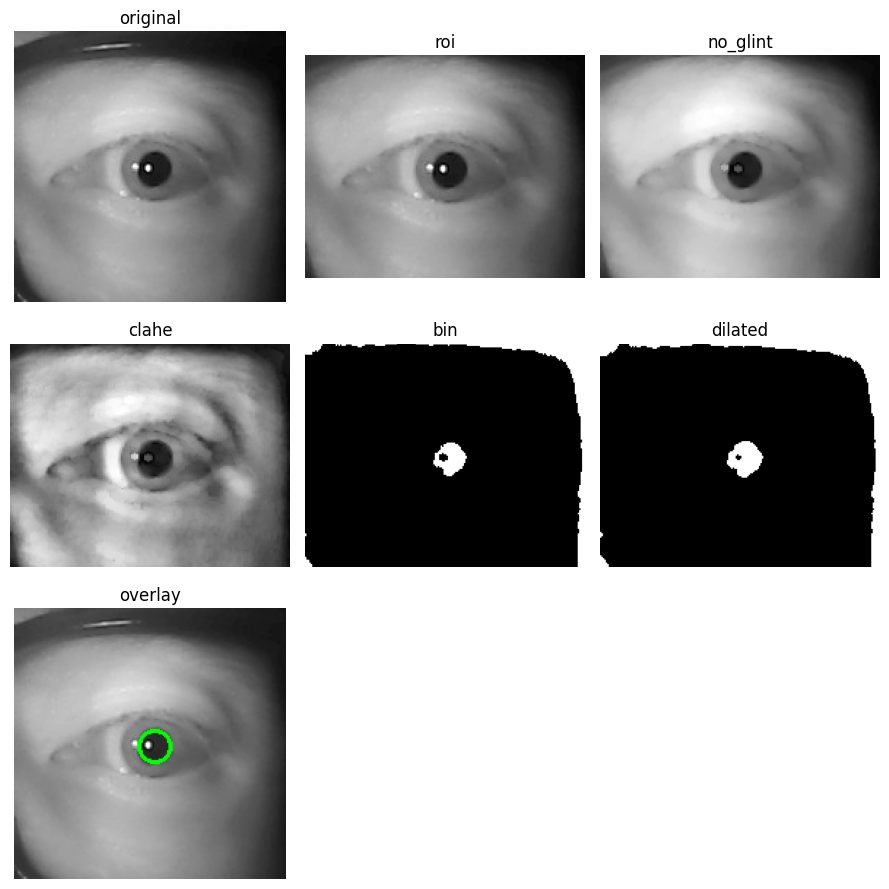

In [5]:
# 셀 5: 한 장 테스트

# 예시: s01 LEYE 1번 프레임 (원하는 파일로 바꿔도 됨)
test_path = DATASET_ROOT / "s01" / "VR" / "IR" / "s01_VR_IR_F_LEYE_0001.png"
print("test_path:", test_path)

cx, cy, r, dbg = process_vr_single(test_path)

print("검출 결과(cx, cy, r):", cx, cy, r)

show_many(
    [dbg["original"], dbg["roi"], dbg["roi_no_glint"], dbg["roi_clahe"],
     dbg["roi_bin"], dbg["roi_dil"], dbg["overlay"]],
    ["original", "roi", "no_glint", "clahe", "bin", "dilated", "overlay"],
    cols=3,
    size=3,
)


In [6]:
# 셀 6: VR 전체 데이터셋 배치 처리

RESULTS_VR_DIR.mkdir(parents=True, exist_ok=True)
img_out_root = RESULTS_VR_DIR / "images"
img_out_root.mkdir(parents=True, exist_ok=True)

csv_path = RESULTS_VR_DIR / "pupil_result_vr.csv"

subject_stats = defaultdict(lambda: [0, 0])  # [processed, detected]
rows = []

subjects = ["s01", "s02", "s03", "s04", "t01", "t02"]  # 필요하면 수정

for sub in subjects:
    vr_ir_dir = DATASET_ROOT / sub / "VR" / "IR"
    if not vr_ir_dir.exists():
        print(f"[WARN] {vr_ir_dir} 없음, 스킵")
        continue

    out_sub_dir = img_out_root / sub
    out_sub_dir.mkdir(parents=True, exist_ok=True)

    for fname in sorted(os.listdir(vr_ir_dir)):
        if not fname.lower().endswith((".png", ".jpg", ".jpeg", ".bmp")):
            continue

        if "_LEYE_" in fname:
            eye_label = "L"
        elif "_REYE_" in fname:
            eye_label = "R"
        else:
            continue

        fpath = vr_ir_dir / fname
        subject_stats[sub][0] += 1

        cx, cy, r, dbg = process_vr_single(fpath)
        vis = dbg["overlay"].copy()

        lcx = lcy = rcx = rcy = 0.0
        if cx is not None:
            if eye_label == "L":
                lcx, lcy = cx, cy
            else:
                rcx, rcy = cx, cy
            subject_stats[sub][1] += 1

        # 이미지 저장
        out_path = out_sub_dir / fname
        ok = cv2.imwrite(str(out_path), vis)
        print("SAVE:", out_path, "OK?", ok)

        rows.append([fname, lcx, lcy, rcx, rcy])

# CSV 저장
with csv_path.open("w", newline="", encoding="utf-8") as f:
    writer = csv.writer(f)
    writer.writerow(["FILENAME", "LEYE_CENTER_X", "LEYE_CENTER_Y",
                     "REYE_CENTER_X", "REYE_CENTER_Y"])
    writer.writerows(rows)

print("CSV 저장:", csv_path)

# 통계 출력
print("\n=== VR subject-wise detection rate ===")
total_p = total_d = 0
for sub, (proc, det) in subject_stats.items():
    total_p += proc
    total_d += det
    rate = det / proc * 100.0 if proc > 0 else 0.0
    print(f"{sub:<4} | processed={proc:<4}  detected={det:<4}  rate={rate:5.2f}%")

overall = total_d / total_p * 100.0 if total_p > 0 else 0.0
print(f"TOTAL: processed={total_p}, detected={total_d}, overall={overall:5.2f}%")


SAVE: c:\Users\CONSOMMES\Downloads\DIP\202311322_EIS\Code\results_vr\images\s01\s01_VR_IR_F_LEYE_0001.png OK? True
SAVE: c:\Users\CONSOMMES\Downloads\DIP\202311322_EIS\Code\results_vr\images\s01\s01_VR_IR_F_LEYE_0051.png OK? True
SAVE: c:\Users\CONSOMMES\Downloads\DIP\202311322_EIS\Code\results_vr\images\s01\s01_VR_IR_F_LEYE_0101.png OK? True
SAVE: c:\Users\CONSOMMES\Downloads\DIP\202311322_EIS\Code\results_vr\images\s01\s01_VR_IR_F_LEYE_0151.png OK? True
SAVE: c:\Users\CONSOMMES\Downloads\DIP\202311322_EIS\Code\results_vr\images\s01\s01_VR_IR_F_LEYE_0201.png OK? True
SAVE: c:\Users\CONSOMMES\Downloads\DIP\202311322_EIS\Code\results_vr\images\s01\s01_VR_IR_F_LEYE_0251.png OK? True
SAVE: c:\Users\CONSOMMES\Downloads\DIP\202311322_EIS\Code\results_vr\images\s01\s01_VR_IR_F_LEYE_0301.png OK? True
SAVE: c:\Users\CONSOMMES\Downloads\DIP\202311322_EIS\Code\results_vr\images\s01\s01_VR_IR_F_LEYE_0351.png OK? True
SAVE: c:\Users\CONSOMMES\Downloads\DIP\202311322_EIS\Code\results_vr\images\s01\